# Adding and using a custom waveform in PyCBC Inference

By default, PyCBC makes available waveform approximants defined either internally or from the lalsimulation package. However, there are times when these waveform models may be insufficient. Perhaps you have your own waveform model you'd like to test, or you'd like to hook up PyCBC to some external package. An alternative to modifying PyCBC directly is to provide a waveform plugin. This tutorial will walk you through how to make a waveform plugin and how to use it from PyCBC Inference. There is some [brief documentation here](https://pycbc.org/pycbc/latest/html/waveform_plugin.html). 

### Make sure the software is set up ###


In [18]:
import sys
!{sys.executable} -m pip install pycbc ligo-common lalsuite --no-cache-dir
!{sys.executable} -m pip install git+https://github.com/gwastro/example-waveform-plugin

  Cloning https://github.com/gwastro/example-waveform-plugin to /tmp/pip-req-build-_v4oom5m
  Running command git clone -q https://github.com/gwastro/example-waveform-plugin /tmp/pip-req-build-_v4oom5m


  Created wheel for pycbc-revchirp: filename=pycbc_revchirp-0.0.dev0-py3-none-any.whl size=2207 sha256=33264520f52e2d07bc76a462b2ab4923c99edea18bf364338b10776504e62073
  Stored in directory: /tmp/pip-ephem-wheel-cache-efbylvim/wheels/02/51/26/2b6693923ca77c5677f7f04aadfe22c55bea5e35f3c415c70a
Successfully built pycbc-revchirp


### Well, what waveform approximants are available to use? ###

There are two type of waveform approximants, fourier-domain, and time-domain. We can check which ones PyCBC knows about by quering the pycbc.waveform package as follows. Note that some approximants may require additional data files (notably ones with 'ROM' in the name).

In [19]:
from pycbc.waveform import td_approximants, fd_approximants

print(td_approximants())
print(fd_approximants())

['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'TaylorF2', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBNRv2_ROM_DoubleSpin', 'EOBNRv2_ROM', 'EOBNRv2HM_ROM', 'SEOBNRv2_ROM_DoubleSpin_HI', 'SEOBNRv4_ROM', 'IMRPheno

Text(0, 0.5, 'Strain')

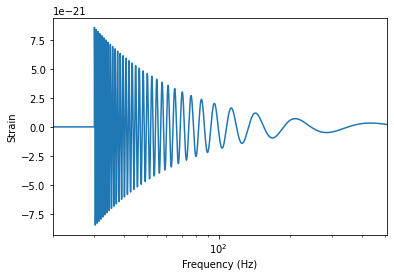

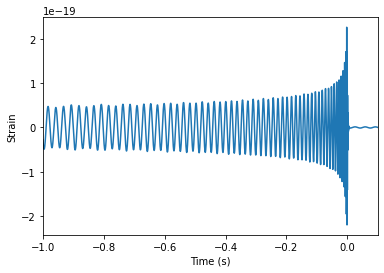

In [20]:
# Let's pick a FD waveform and plot it.
import pylab
from pycbc.waveform import get_fd_waveform

hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=10, mass2=10,
                         f_lower=30, delta_f=1.0/64)

pylab.figure(0)
pylab.plot(hp.sample_frequencies, hp.real())
pylab.xscale('log')
pylab.xlim(20, 512)
pylab.xlabel('Frequency (Hz)')
pylab.ylabel('Strain')

pylab.figure(1)
ht = hp.to_timeseries().cyclic_time_shift(-5)
pylab.plot(ht.sample_times, ht.real())
pylab.xlim(-1, .1)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')


### Le'ts make our own waveform model and add it to PyCBC ###

In this section, we'll write our own waveform model function. For simplicity, we'll just show the procedure for creating a frequency-domain model. It is similar for time-domain. 

In [21]:
# Custom Waveform
def my_waveform(new_param=0, **params):
    # We are lazy, so we'll base our waveform on a modification of IMRPhenomD, but 
    # add one new parameter.
    from pycbc.waveform import get_fd_waveform
    if 'approximant' in params:
        params.pop('approximant')
    hp, hc = get_fd_waveform(approximant="IMRPhenomD", **params)
    
    # If you want to fully build a custom function, it should accept abitrary keyword
    # arguments as this function does. Frequency domain waveforms should also make 
    # use of delta_f, and f_lower to determine the frequency stepping and starting
    # frequency resepectively
    
    # our new_param is strange as it will just scale one of the polarizations  
    
    # For a general waveform, you should return a pycbc FrequencySeries for each 
    # polarization. It is also generally assumed that the waveform is aligned so
    # that it peaks (or merges) at the end of the equivelant time-domain vector.
    return hp * new_param, hc 

In [22]:
# Now we can add this waveform to pycbc directly. This will make the waveform 
# accessible from get_fd_waveform and higher level functions.
from pycbc.waveform import add_custom_waveform

# To protect against overriding an existing waveform, you'll get an error if you run
# this function twice, to override this, you can set force=True.
# add_custom_waveform('my_waveform', my_waveform, 'frequency')
add_custom_waveform('my_waveform', my_waveform, 'frequency', force=True)

Text(0, 0.5, 'Strain')

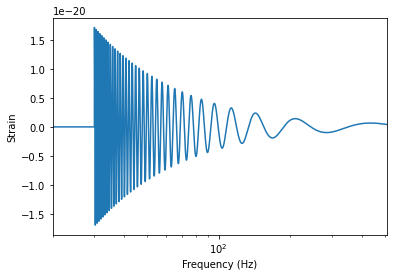

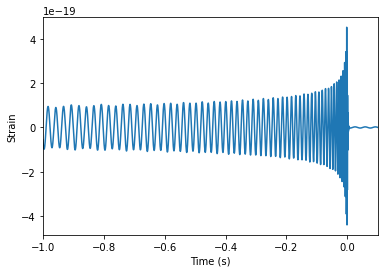

In [23]:
hp, hc = get_fd_waveform(approximant="my_waveform", new_param=2.0,
                         mass1=10, mass2=10, 
                         f_lower=30, delta_f=1.0/64)

pylab.figure(0)
pylab.plot(hp.sample_frequencies, hp.real())
pylab.xscale('log')
pylab.xlim(20, 512)
pylab.xlabel('Frequency (Hz)')
pylab.ylabel('Strain')

pylab.figure(1)
ht = hp.to_timeseries().cyclic_time_shift(-5)
pylab.plot(ht.sample_times, ht.real())
pylab.xlim(-1, .1)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

## So, how do we have PyCBC automatically add our waveform? ##

Above, we added a waveform manually using the 'add_custom_waveform' function. However, if you are running pycbc_inference, or similar codes, it may be more convenient to have PyCBC automatically discover your new waveform. To do so, you make a waveform plugin package. There is a complete working [example here](https://github.com/gwastro/example-waveform-plugin).

### Example Reverse Chirp Waveform ###

Text(0, 0.5, 'Strain')

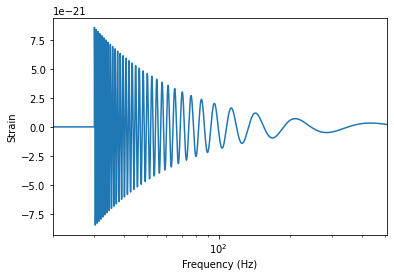

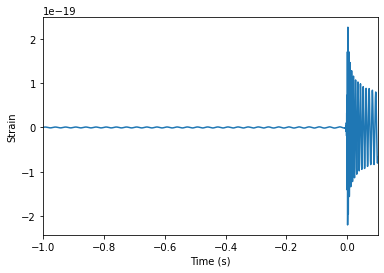

In [24]:
# At the beginning of this tutorial, we installed the package 'pycbc-revchirp'.
# a new waveform approximant to PyCBC which we can now generate. 


hp, hc = get_fd_waveform(approximant="revchirp", new_param=2.0,
                         mass1=10, mass2=10, 
                         f_lower=30, delta_f=1.0/64)

pylab.figure(0)
pylab.plot(hp.sample_frequencies, hp.real())
pylab.xscale('log')
pylab.xlim(20, 512)
pylab.xlabel('Frequency (Hz)')
pylab.ylabel('Strain')

pylab.figure(1)
ht = hp.to_timeseries().cyclic_time_shift(-5)
pylab.plot(ht.sample_times, ht.real())
pylab.xlim(-1, .1)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

### Building the plugin package ###

To make a plugin package (or advertise a plugin from an existin package), you need to (1) create a function that generates the waveform, and (2) modify the python package setup.py to advertise the function to PyCBC. Below is the code from our example reverse chirp waveform plugin.

### Revchirp.py ###
```python
""" Reverse chirping waveform model using IMRPhenomD as a a base
"""

# Notes on style:
#
# For example purposes only of how to advertise a waveform model to PyCBC
# Function should take kwargs only, and must accept abitrary kwargs.
# 'newparam' is an example of adding a new argument.
def reverse_chirp_fd(newparam=0.0, **kwds):
    from pycbc.waveform import get_fd_waveform

    if 'approximant' in kwds:
        kwds.pop("approximant")
    hp, hc = get_fd_waveform(approximant="IMRPhenomD", **kwds)

    return hp.conj(), hc.conj() + newparam

def reverse_chirp_td(**kwds):
    import numpy
    from pycbc.waveform import get_td_waveform

    if 'approximant' in kwds:
        kwds.pop("approximant")
    hp, hc = get_td_waveform(approximant="IMRPhenomD", **kwds)

    return (hp.to_frequencyseries().conj().to_timeseries(),
            hp.to_frequencyseries().conj().to_timeseries())
```

#### Modifying Setup.py ####

Below is an example setup.py which has been modified to advertise the existence of the waveform plugin. The only change is to provide an 'entry_points' option to the setup function. This defines, a unique key used by pycbc to find which packages have a plugin, the path to the function within your package, and the name of the approximant. 

                    (Feature name): (approximant name) = (module):(function_name)
    entry_points = {"pycbc.waveform.td":"revchirp = revchirp:reverse_chirp_td",
                    "pycbc.waveform.fd":"revchirp = revchirp:reverse_chirp_fd"},
                    
Note that the 'module' name here can be a dotted path (i.e. package_name.module), so you can have the module anywhere in your distribution.

### Setup.py ###
```python
#!/usr/bin/env python
"""
setup.py file for reverse chirp example pycbc waveform plugin package
"""

from setuptools import Extension, setup, Command
from setuptools import find_packages

VERSION = '0.0.dev0'

setup (
    name = 'pycbc-revchirp',
    version = VERSION,
    description = 'An example waveform plugin for PyCBC',
    author = 'The PyCBC team',
    author_email = 'alex.nitz@gmail.org',
    url = 'http://www.pycbc.org/',
    download_url = 'https://github.com/gwastro/revchirp/tarball/v%s' % VERSION,
    keywords = ['pycbc', 'signal processing', 'gravitational waves'],
    install_requires = ['pycbc'],
    py_modules = ['revchirp'],
    entry_points = {"pycbc.waveform.td":"revchirp = revchirp:reverse_chirp_td",
                    "pycbc.waveform.fd":"revchirp = revchirp:reverse_chirp_fd"},
)
````

## Using our custom waveform in inference ##

There is no extra step to start using your custom waveform in pycbc inference, simply provide it as the approximant choice as you would any other wavefor model. If you have added any arguments, you'll need to provide them either as varaible or static arguments. You can set priors on them as you would any other parameter.

Below is a portion of a config file, which demonstrates how you would modify it to make use of your new waveform.

```
[variable_params]
; waveform parameters that will vary in MCMC
delta_tc = 
mass1 =
mass2 =
distance =
coa_phase =
inclination =
polarization =
ra =
dec =
newparam =

[static_params]
; waveform parameters that will not change in MCMC
approximant = revchirp
f_lower = 20
f_ref = 20

[prior-newparam]
name = uniform
min-newparam = -2.0
max-newparam = 2.0

....
....
```

## Suggested Problem ##

* Add some trivial new parameter to a custom waveform based on TaylorF2. Repeat the exersizes in the first inference tutorial to estimate the parameters within a notebook.